In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,matthews_corrcoef


import xgboost as xgb

In [2]:
df = pd.read_csv('../Feature Engineering/EPL_Final_cleaned_features.csv')
df.head(5)

,Temperature,Humidity,WindDirection,Precipitation,WindSpeed,Home_Prv_FTR,Home_Prv_FTHG,Home_Prv_HS,Home_Prv_HST,Home_Prv_HF,...,WeatherCode_Clear,WeatherCode_Clouds,WeatherCode_Drizzle,WeatherCode_Fog,WeatherCode_Haze,WeatherCode_Mist,WeatherCode_Rain,WeatherCode_Snow,Time_of_Day_Afternoon,Time_of_Day_Evening
0,1.520994,-0.945689,0.186303,-0.36088,1.697256,0.0,1.0,14.0,3.0,10.0,...,0,1,0,0,0,0,0,0,1,0
1,1.843288,-0.812861,0.509638,-0.36088,1.297697,0.0,1.0,14.0,5.0,9.0,...,1,0,0,0,0,0,0,0,1,0
2,1.739561,-0.680033,0.509638,-0.36088,0.571225,0.0,0.0,6.0,2.0,16.0,...,0,0,0,0,0,0,1,0,1,0
3,1.335768,-0.414377,0.822195,-0.36088,0.284269,0.0,0.0,15.0,1.0,3.0,...,0,1,0,0,0,0,0,0,1,0
4,0.963463,-0.015893,0.940751,-0.36088,1.297697,0.0,2.0,30.0,10.0,14.0,...,0,1,0,0,0,0,0,0,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1099 entries, 0 to 1098
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Temperature                1099 non-null   float64
 1   Humidity                   1099 non-null   float64
 2   WindDirection              1099 non-null   float64
 3   Precipitation              1099 non-null   float64
 4   WindSpeed                  1099 non-null   float64
 5   Home_Prv_FTR               1099 non-null   float64
 6   Home_Prv_FTHG              1099 non-null   float64
 7   Home_Prv_HS                1099 non-null   float64
 8   Home_Prv_HST               1099 non-null   float64
 9   Home_Prv_HF                1099 non-null   float64
 10  Home_Prv_HC                1099 non-null   float64
 11  Home_Prv_HY                1099 non-null   float64
 12  Home_Prv_HR                1099 non-null   float64
 13  Home_Prv_3_FTHG            1099 non-null   float

In [4]:
train_data = df[df['season'].isin(['2019-2020', '2020-2021'])]
test_data = df[df['season'] == '2021-2022']

### Model with Weather Data:

In [6]:
# Splitting into features and target variable
X_train = train_data.drop(columns=['FTR','Date', 'Time', 'season'])
y_train = train_data['FTR']
X_test = test_data.drop(columns=['FTR','Date', 'Time', 'season'])
y_test = test_data['FTR']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((722, 37), (722,), (377, 37), (377,))

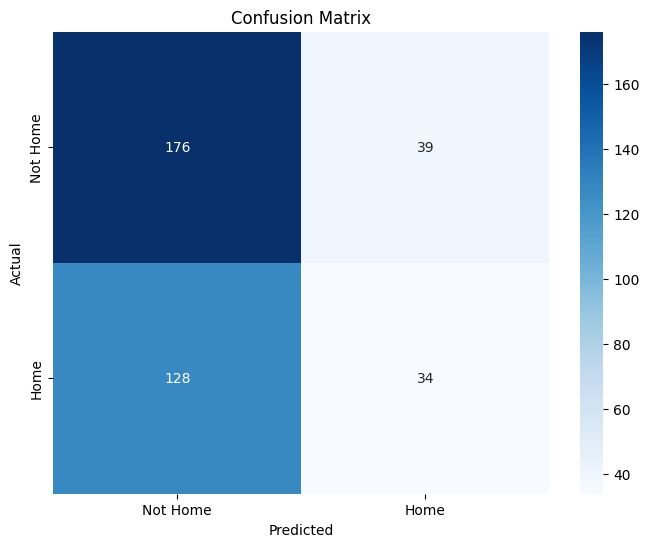

{'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
MCC: 0.03568097499065309
accuracy: 0.5570291777188329
              precision    recall  f1-score   support

           0       0.58      0.82      0.68       215
           1       0.47      0.21      0.29       162

    accuracy                           0.56       377
   macro avg       0.52      0.51      0.48       377
weighted avg       0.53      0.56      0.51       377



In [8]:
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Using GridSearchCV to find the best hyperparameters (with weather data)
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best parameters from GridSearch
best_params = grid_search_rf.best_params_

# Building the Random Forest model with the best parameters
model_rf = RandomForestClassifier(**best_params, random_state=42)
model_rf.fit(X_train, y_train)

# Predicting on the test data
y_pred = model_rf.predict(X_test)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)

### Model without Weather Data:

In [9]:
# Splitting into features and target variable
X_train = train_data.drop(columns=['FTR','Date', 'Time', 'season','Temperature', 'Humidity', 'WindDirection', 'Precipitation', 'WindSpeed', 
                                   'WeatherCode_Clear', 'WeatherCode_Clouds', 'WeatherCode_Drizzle', 'WeatherCode_Fog', 'WeatherCode_Haze', 'WeatherCode_Mist', 'WeatherCode_Rain', 'WeatherCode_Snow'])
y_train = train_data['FTR']
X_test = test_data.drop(columns=['FTR','Date', 'Time', 'season','Temperature', 'Humidity', 'WindDirection', 'Precipitation', 'WindSpeed', 
                                   'WeatherCode_Clear', 'WeatherCode_Clouds', 'WeatherCode_Drizzle', 'WeatherCode_Fog', 'WeatherCode_Haze', 'WeatherCode_Mist', 'WeatherCode_Rain', 'WeatherCode_Snow'])
y_test = test_data['FTR']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((722, 24), (722,), (377, 24), (377,))

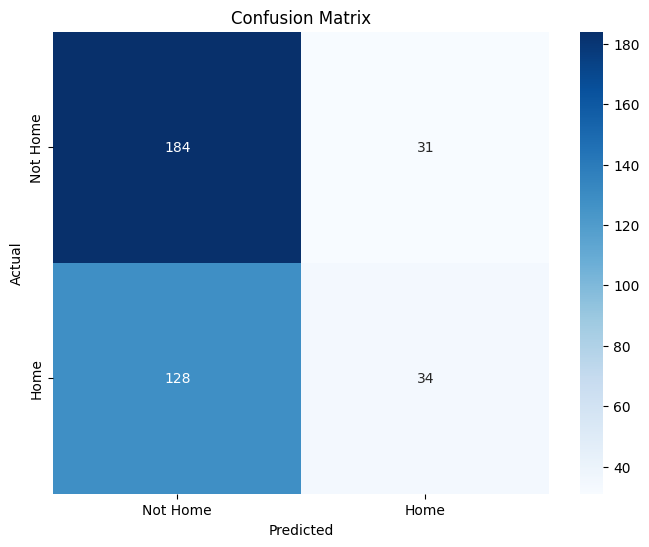

{'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
MCC: 0.08608853306294989
accuracy: 0.5782493368700266
              precision    recall  f1-score   support

           0       0.59      0.86      0.70       215
           1       0.52      0.21      0.30       162

    accuracy                           0.58       377
   macro avg       0.56      0.53      0.50       377
weighted avg       0.56      0.58      0.53       377



In [10]:
rf_model = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Using GridSearchCV to find the best hyperparameters (with weather data)
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best parameters from GridSearch
best_params = grid_search_rf.best_params_

# Building the Random Forest model with the best parameters
model_rf = RandomForestClassifier(**best_params, random_state=42)
model_rf.fit(X_train, y_train)

# Predicting on the test data
y_pred = model_rf.predict(X_test)

# Calculate accuracy and classification report
mcc = matthews_corrcoef(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_report_output = classification_report(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Home', 'Home'], yticklabels=['Not Home', 'Home'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(best_params)
print(f'MCC: {mcc}')
print(f'accuracy: {accuracy}')
print(classification_report_output)